In [57]:
from pydataset import data
import pandas as pd
from env import user, host, password
import numpy as np

def get_db_url(user, host, password, db_name):
    return f"mysql+pymysql://{user}:{password}@{host}/{db_name}"

### 1. Load the mpg dataset. Read the documentation for it, and use the data to answer these questions:

In [46]:
mpg = data("mpg")
mpg.columns

Index(['manufacturer', 'model', 'displ', 'year', 'cyl', 'trans', 'drv', 'cty',
       'hwy', 'fl', 'class'],
      dtype='object')

#### * On average, which manufacturer has the best miles per gallon?

In [47]:
mpg.groupby("manufacturer")[['cty', 'hwy']].agg("mean").nlargest(1, ['cty', 'hwy'], keep = "all")

,cty,hwy
manufacturer,,
honda,24.444444,32.555556


### * How many different manufacturers are there?

In [49]:
print(f"There are {len(mpg.groupby('manufacturer'))} manufacturers.")
#Alternative solution
mpg.manufacturer.nunique()

There are 15 manufacturers.


15

#### * How many different models are there?

In [50]:
print(f"There are {len(mpg.groupby('model'))} models.")
#Alternative solution
mpg.model.nunique()

There are 38 models.


38

#### * Do automatic or manual cars have better miles per gallon?

In [60]:
def assign_transmission(trans):
    if trans.find("auto") > -1:
        return "auto"
    else:
        return "manual"

mpg['auto_or_manual'] = mpg.trans.apply(assign_transmission)
mpg.groupby('auto_or_manual')[['cty', 'hwy']].agg("mean").sort_values(by = ['cty', 'hwy'], ascending = False)
# Manuals

,cty,hwy
auto_or_manual,,
manual,18.675325,25.779221
auto,15.968153,22.292994


In [62]:
# Alternative solution using np.where()
mpg['transmission_category'] = np.where(mpg.trans.str.startswith("a"), "auto", "manual")
mpg.groupby("transmission_category")[['cty', 'hwy']].mean().sort_values(by = ['cty', 'hwy'], ascending = False)

,cty,hwy
transmission_category,,
manual,18.675325,25.779221
auto,15.968153,22.292994


### 2. Joining and Merging

In [63]:
import numpy as np
users = pd.DataFrame({
    'id': [1, 2, 3, 4, 5, 6],
    'name': ['bob', 'joe', 'sally', 'adam', 'jane', 'mike'],
    'role_id': [1, 2, 3, 3, np.nan, np.nan]
})
users

,id,name,role_id
0,1,bob,1.0
1,2,joe,2.0
2,3,sally,3.0
3,4,adam,3.0
4,5,jane,NaN
5,6,mike,NaN


In [64]:
roles = pd.DataFrame({
    'id': [1, 2, 3, 4],
    'name': ['admin', 'author', 'reviewer', 'commenter']
})
roles

,id,name
0,1,admin
1,2,author
2,3,reviewer
3,4,commenter


In [65]:
# Right join would have all the roles whether or not there is a match
pd.merge(users, roles, left_on = "role_id", right_on = "id", how = "right", indicator = True)

,id_x,name_x,role_id,id_y,name_y,_merge
0,1.0,bob,1.0,1,admin,both
1,2.0,joe,2.0,2,author,both
2,3.0,sally,3.0,3,reviewer,both
3,4.0,adam,3.0,3,reviewer,both
4,NaN,NaN,NaN,4,commenter,right_only


In [66]:
# Outer join would return results from both tables whether or not there is a match
pd.merge(users, roles, left_on = "role_id", right_on = "id", how = "outer", indicator = True)

,id_x,name_x,role_id,id_y,name_y,_merge
0,1.0,bob,1.0,1.0,admin,both
1,2.0,joe,2.0,2.0,author,both
2,3.0,sally,3.0,3.0,reviewer,both
3,4.0,adam,3.0,3.0,reviewer,both
4,5.0,jane,NaN,NaN,NaN,left_only
5,6.0,mike,NaN,NaN,NaN,left_only
6,NaN,NaN,NaN,4.0,commenter,right_only


In [ ]:
# If you drop the foreign keys you will not be able to join the tables
users.drop(columns = ['role_id'], inplace = True)
roles.drop(columns = ['id'], inplace = True)
pd.merge(users, roles, left_on = "role_id", right_on = "id", how = "inner")

### 3. Getting data from SQL databases

#### * Create a function named get_db_url. It should accept a username, hostname, password, and database name and return a url formatted like in the examples in this lesson.

In [2]:
def get_db_url(user, host, password, db_name):
    return f"mysql+pymysql://{user}:{password}@{host}/{db_name}"

#### * Use your function to obtain a connection to the employees database.

In [3]:
from env import user, host, password

In [68]:
url = get_db_url(user, host, password, "employees")
query = """
    SELECT *
        FROM employees
            JOIN dept_emp USING(emp_no)
        WHERE to_date > now();
"""

pd.read_sql(query, url)

,emp_no,birth_date,first_name,last_name,gender,hire_date,dept_no,from_date,to_date
0,10001,1953-09-02,Georgi,Facello,M,1986-06-26,d005,1986-06-26,9999-01-01
1,10002,1964-06-02,Bezalel,Simmel,F,1985-11-21,d007,1996-08-03,9999-01-01
2,10003,1959-12-03,Parto,Bamford,M,1986-08-28,d004,1995-12-03,9999-01-01
3,10004,1954-05-01,Chirstian,Koblick,M,1986-12-01,d004,1986-12-01,9999-01-01
4,10005,1955-01-21,Kyoichi,Maliniak,M,1989-09-12,d003,1989-09-12,9999-01-01
...,...,...,...,...,...,...,...,...,...
240119,499995,1958-09-24,Dekang,Lichtner,F,1993-01-12,d004,1997-06-02,9999-01-01
240120,499996,1953-03-07,Zito,Baaz,M,1990-09-27,d004,1996-05-13,9999-01-01
240121,499997,1961-08-03,Berhard,Lenart,M,1986-04-21,d005,1987-08-30,9999-01-01
240122,499998,1956-09-05,Patricia,Breugel,M,1993-10-13,d002,1993-12-27,9999-01-01


#### * Intentionally make a typo in the database url. What kind of error message do you see?

In [ ]:
pd.read_sql(query, url + "typo")

#### * Intentionally make an error in your SQL query. What does the error message look like?

In [ ]:
pd.read_sql(query + "typo", url)

#### * Read the employees and titles tables into two separate dataframes

In [69]:
employees = pd.read_sql(query, url)
employees

,emp_no,birth_date,first_name,last_name,gender,hire_date,dept_no,from_date,to_date
0,10001,1953-09-02,Georgi,Facello,M,1986-06-26,d005,1986-06-26,9999-01-01
1,10002,1964-06-02,Bezalel,Simmel,F,1985-11-21,d007,1996-08-03,9999-01-01
2,10003,1959-12-03,Parto,Bamford,M,1986-08-28,d004,1995-12-03,9999-01-01
3,10004,1954-05-01,Chirstian,Koblick,M,1986-12-01,d004,1986-12-01,9999-01-01
4,10005,1955-01-21,Kyoichi,Maliniak,M,1989-09-12,d003,1989-09-12,9999-01-01
...,...,...,...,...,...,...,...,...,...
240119,499995,1958-09-24,Dekang,Lichtner,F,1993-01-12,d004,1997-06-02,9999-01-01
240120,499996,1953-03-07,Zito,Baaz,M,1990-09-27,d004,1996-05-13,9999-01-01
240121,499997,1961-08-03,Berhard,Lenart,M,1986-04-21,d005,1987-08-30,9999-01-01
240122,499998,1956-09-05,Patricia,Breugel,M,1993-10-13,d002,1993-12-27,9999-01-01


In [71]:
titles = pd.read_sql("SELECT * FROM titles;", url)
titles

,emp_no,title,from_date,to_date
0,10001,Senior Engineer,1986-06-26,9999-01-01
1,10002,Staff,1996-08-03,9999-01-01
2,10003,Senior Engineer,1995-12-03,9999-01-01
3,10004,Engineer,1986-12-01,1995-12-01
4,10004,Senior Engineer,1995-12-01,9999-01-01
...,...,...,...,...
443303,499997,Engineer,1987-08-30,1992-08-29
443304,499997,Senior Engineer,1992-08-29,9999-01-01
443305,499998,Senior Staff,1998-12-27,9999-01-01
443306,499998,Staff,1993-12-27,1998-12-27


#### * Visualize the number of employees with each title.

In [87]:
titles.groupby('title').emp_no.agg("count").sort_values()

title
Manager                   24
Assistant Engineer     15128
Technique Leader       15159
Senior Staff           92853
Senior Engineer        97750
Staff                 107391
Engineer              115003
Name: emp_no, dtype: int64

<AxesSubplot:ylabel='title'>

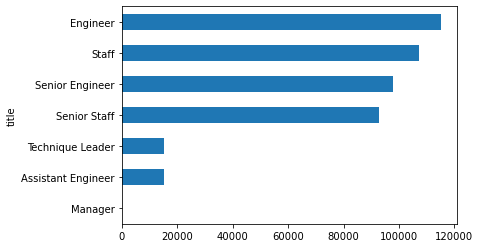

In [86]:
titles.groupby('title').emp_no.agg("count").sort_values().plot.barh()

#### * Join the employees and titles dataframes together.

In [78]:
emp_and_title = pd.merge(employees, titles, left_on = "emp_no", right_on = "emp_no")
#alternative syntax
# emp_and_title = pd.merge(employees, titles, on = "emp_no")

#### * Visualize how frequently employees change titles.

In [75]:
emp_and_title.groupby('emp_no').title.agg("count")

emp_no
10001     1
10002     1
10003     1
10004     2
10005     2
         ..
499995    1
499996    2
499997    2
499998    2
499999    1
Name: title, Length: 240124, dtype: int64

<AxesSubplot:xlabel='emp_no', ylabel='titles held'>

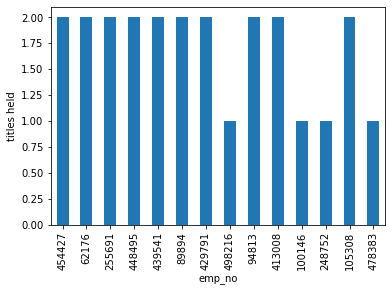

In [91]:
emp_and_title.groupby('emp_no').title.agg("count").sample(14).plot.bar(ylabel = "titles held")

#### * For each title, find the hire date of the employee that was hired most recently with that title.

In [79]:
emp_and_title.groupby('title').hire_date.agg("max")

title
Assistant Engineer    1999-12-24
Engineer              2000-01-23
Manager               1992-02-05
Senior Engineer       2000-01-01
Senior Staff          2000-01-13
Staff                 2000-01-12
Technique Leader      1999-12-15
Name: hire_date, dtype: object

#### * Write the code necessary to create a cross tabulation of the number of titles by department.

In [80]:
dept_query = """SELECT *
                    FROM departments;"""
departments = pd.read_sql(dept_query, url)
emp_title_dept = pd.merge(emp_and_title, departments, left_on = "dept_no", right_on = "dept_no")
emp_title_dept

,emp_no,birth_date,first_name,last_name,gender,hire_date,dept_no,from_date_x,to_date_x,title,from_date_y,to_date_y,dept_name
0,10001,1953-09-02,Georgi,Facello,M,1986-06-26,d005,1986-06-26,9999-01-01,Senior Engineer,1986-06-26,9999-01-01,Development
1,10006,1953-04-20,Anneke,Preusig,F,1989-06-02,d005,1990-08-05,9999-01-01,Senior Engineer,1990-08-05,9999-01-01,Development
2,10012,1960-10-04,Patricio,Bridgland,M,1992-12-18,d005,1992-12-18,9999-01-01,Engineer,1992-12-18,2000-12-18,Development
3,10012,1960-10-04,Patricio,Bridgland,M,1992-12-18,d005,1992-12-18,9999-01-01,Senior Engineer,2000-12-18,9999-01-01,Development
4,10014,1956-02-12,Berni,Genin,M,1987-03-11,d005,1993-12-29,9999-01-01,Engineer,1993-12-29,9999-01-01,Development
...,...,...,...,...,...,...,...,...,...,...,...,...,...
371238,499868,1956-11-14,Shaz,Bierbaum,M,1988-11-01,d002,1996-10-03,9999-01-01,Staff,1996-10-03,9999-01-01,Finance
371239,499873,1960-12-10,Kasidit,Picel,F,1986-04-21,d002,1997-08-03,9999-01-01,Staff,1997-08-03,9999-01-01,Finance
371240,499977,1956-06-05,Martial,Weisert,F,1996-09-17,d002,1999-12-28,9999-01-01,Staff,1999-12-28,9999-01-01,Finance
371241,499998,1956-09-05,Patricia,Breugel,M,1993-10-13,d002,1993-12-27,9999-01-01,Senior Staff,1998-12-27,9999-01-01,Finance


In [93]:
pd.crosstab(emp_title_dept.title, emp_title_dept.dept_name)

dept_name,Customer Service,Development,Finance,Human Resources,Marketing,Production,Quality Management,Research,Sales
title,,,,,,,,,
Assistant Engineer,240,5551,0,0,0,4670,1280,316,0
Engineer,1927,42111,0,0,0,36308,10174,2416,0
Manager,4,2,2,2,2,4,4,2,2
Senior Engineer,1790,38816,0,0,0,33627,9459,2250,0
Senior Staff,11271,1085,9546,9825,11291,1123,0,9093,28797
Staff,11836,1123,9995,10407,11885,1185,0,9646,30117
Technique Leader,241,5478,0,0,0,4724,1295,321,0


### 4. Use your get_db_url function to help you explore the data from the chipotle database. Use the data to answer the following questions:

In [42]:
chipotle_url = get_db_url(user, host, password, "chipotle")
chipotle_query = """SELECT *
                        FROM orders"""

chipotle = pd.read_sql(chipotle_query, chipotle_url)
chipotle

,id,order_id,quantity,item_name,choice_description,item_price
0,1,1,1,Chips and Fresh Tomato Salsa,nan,$2.39
1,2,1,1,Izze,[Clementine],$3.39
2,3,1,1,Nantucket Nectar,[Apple],$3.39
3,4,1,1,Chips and Tomatillo-Green Chili Salsa,nan,$2.39
4,5,2,2,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Black Beans, Rice, Cheese, Sour Cream]]",$16.98
...,...,...,...,...,...,...
4617,4618,1833,1,Steak Burrito,"[Fresh Tomato Salsa, [Rice, Black Beans, Sour Cream, Cheese, Lettuce, Guacamole]]",$11.75
4618,4619,1833,1,Steak Burrito,"[Fresh Tomato Salsa, [Rice, Sour Cream, Cheese, Lettuce, Guacamole]]",$11.75
4619,4620,1834,1,Chicken Salad Bowl,"[Fresh Tomato Salsa, [Fajita Vegetables, Pinto Beans, Guacamole, Lettuce]]",$11.25
4620,4621,1834,1,Chicken Salad Bowl,"[Fresh Tomato Salsa, [Fajita Vegetables, Lettuce]]",$8.75


#### * What is the total price for each order?

In [43]:
def convert_to_float(price):
    price = price.replace("$", "")
    return float(price)

chipotle['float_price'] = chipotle.item_price.apply(convert_to_float)
#alternative solution
# chipotle['float_price'] = chipotle.item_price.str.replace("$", "").astype(float)
chipotle.groupby('order_id').float_price.agg("sum")

order_id
1       11.56
2       16.98
3       12.67
4       21.00
5       13.70
        ...  
1830    23.00
1831    12.90
1832    13.20
1833    23.50
1834    28.75
Name: float_price, Length: 1834, dtype: float64

#### * What are the most popular 3 items?

In [94]:
chipotle.groupby('item_name').quantity.agg("sum").sort_values(ascending = False).head(3)

item_name
Chicken Bowl           761
Chicken Burrito        591
Chips and Guacamole    506
Name: quantity, dtype: int64

#### * Which item has produced the most revenue?

In [45]:
chipotle.groupby('item_name').float_price.agg("sum").sort_values(ascending = False).head(1)

item_name
Chicken Bowl    7342.73
Name: float_price, dtype: float64

### Bonus:  For even more practice with pandas, you can do the exercises from the SQL module, but instead of using SQL to do the aggregation, sorting, joining, etc, use pandas. That is, read the data from all of the tables into pandas dataframes and manipulate the dataframes.

In [5]:
world_url = get_db_url(user, host, password, "world")

In [4]:
world_query = """SELECT *
                    FROM city;"""

cities = pd.read_sql(world_query, world_url)
cities

,ID,Name,CountryCode,District,Population
0,1,Kabul,AFG,Kabol,1780000
1,2,Qandahar,AFG,Qandahar,237500
2,3,Herat,AFG,Herat,186800
3,4,Mazar-e-Sharif,AFG,Balkh,127800
4,5,Amsterdam,NLD,Noord-Holland,731200
...,...,...,...,...,...
4074,4075,Khan Yunis,PSE,Khan Yunis,123175
4075,4076,Hebron,PSE,Hebron,119401
4076,4077,Jabaliya,PSE,North Gaza,113901
4077,4078,Nablus,PSE,Nablus,100231


#### * What languages are spoken in Santa Monica?

In [5]:
lang_query = """SELECT *
                    FROM countrylanguage;"""
languages = pd.read_sql(lang_query, world_url)
languages

,CountryCode,Language,IsOfficial,Percentage
0,ABW,Dutch,T,5.3
1,ABW,English,F,9.5
2,ABW,Papiamento,F,76.7
3,ABW,Spanish,F,7.4
4,AFG,Balochi,F,0.9
...,...,...,...,...
979,ZMB,Tongan,F,11.0
980,ZWE,English,T,2.2
981,ZWE,Ndebele,F,16.2
982,ZWE,Nyanja,F,2.2


In [ ]:
cities_languages = pd.merge(cities, languages, left_on = "CountryCode", right_on = "CountryCode")
language_count = cities_languages.groupby('Name').Language.agg("count")
language_count["Santa Monica"]
# 12 languages spoken in Santa Monica

#### * How many different countries are in each region?

In [6]:
country_query = """SELECT *
                        FROM country"""
countries = pd.read_sql(country_query, world_url) 
countries

,Code,Name,Continent,Region,SurfaceArea,IndepYear,Population,LifeExpectancy,GNP,GNPOld,LocalName,GovernmentForm,HeadOfState,Capital,Code2
0,ABW,Aruba,North America,Caribbean,193.0,NaN,103000,78.4,828.0,793.0,Aruba,Nonmetropolitan Territory of The Netherlands,Beatrix,129.0,AW
1,AFG,Afghanistan,Asia,Southern and Central Asia,652090.0,1919.0,22720000,45.9,5976.0,NaN,Afganistan/Afqanestan,Islamic Emirate,Mohammad Omar,1.0,AF
2,AGO,Angola,Africa,Central Africa,1246700.0,1975.0,12878000,38.3,6648.0,7984.0,Angola,Republic,José Eduardo dos Santos,56.0,AO
3,AIA,Anguilla,North America,Caribbean,96.0,NaN,8000,76.1,63.2,NaN,Anguilla,Dependent Territory of the UK,Elisabeth II,62.0,AI
4,ALB,Albania,Europe,Southern Europe,28748.0,1912.0,3401200,71.6,3205.0,2500.0,Shqipëria,Republic,Rexhep Mejdani,34.0,AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,YEM,Yemen,Asia,Middle East,527968.0,1918.0,18112000,59.8,6041.0,5729.0,Al-Yaman,Republic,Ali Abdallah Salih,1780.0,YE
235,YUG,Yugoslavia,Europe,Southern Europe,102173.0,1918.0,10640000,72.4,17000.0,NaN,Jugoslavija,Federal Republic,Vojislav Koštunica,1792.0,YU
236,ZAF,South Africa,Africa,Southern Africa,1221037.0,1910.0,40377000,51.1,116729.0,129092.0,South Africa,Republic,Thabo Mbeki,716.0,ZA
237,ZMB,Zambia,Africa,Eastern Africa,752618.0,1964.0,9169000,37.2,3377.0,3922.0,Zambia,Republic,Frederick Chiluba,3162.0,ZM


In [7]:
countries.groupby("Region").Name.agg("count")

Region
Antarctica                    5
Australia and New Zealand     5
Baltic Countries              3
British Islands               2
Caribbean                    24
Central Africa                9
Central America               8
Eastern Africa               20
Eastern Asia                  8
Eastern Europe               10
Melanesia                     5
Micronesia                    7
Micronesia/Caribbean          1
Middle East                  18
Nordic Countries              7
North America                 5
Northern Africa               7
Polynesia                    10
South America                14
Southeast Asia               11
Southern Africa               5
Southern Europe              15
Southern and Central Asia    14
Western Africa               17
Western Europe                9
Name: Name, dtype: int64

#### * What is the population for each region?

In [8]:
countries.groupby("Region").Population.agg("sum")

Region
Antarctica                            0
Australia and New Zealand      22753100
Baltic Countries                7561900
British Islands                63398500
Caribbean                      38140000
Central Africa                 95652000
Central America               135221000
Eastern Africa                246999000
Eastern Asia                 1507328000
Eastern Europe                307026000
Melanesia                       6472000
Micronesia                       543000
Micronesia/Caribbean                  0
Middle East                   188380700
Nordic Countries               24166400
North America                 309632000
Northern Africa               173266000
Polynesia                        633050
South America                 345780000
Southeast Asia                518541000
Southern Africa                46886000
Southern Europe               144674200
Southern and Central Asia    1490776000
Western Africa                221672000
Western Europe                183

#### * What is the population for each continent?

In [9]:
countries.groupby("Continent").Population.agg("sum")

Continent
Africa            784475000
Antarctica                0
Asia             3705025700
Europe            730074600
North America     482993000
Oceania            30401150
South America     345780000
Name: Population, dtype: int64

#### * What is the average life expectancy globally?

In [10]:
countries.LifeExpectancy.agg("mean")

66.48603603603601

#### * What is the average life expectancy for each region, each continent? Sort the results from shortest to longest

In [13]:
countries.groupby("Region").LifeExpectancy.agg("mean").sort_values().dropna()

Region
Southern Africa              44.820000
Central Africa               50.311111
Eastern Africa               50.810526
Western Africa               52.741176
Southern and Central Asia    61.350000
Southeast Asia               64.400000
Northern Africa              65.385714
Melanesia                    67.140000
Micronesia                   68.085714
Baltic Countries             69.000000
Eastern Europe               69.930000
Middle East                  70.566667
Polynesia                    70.733333
South America                70.946154
Central America              71.025000
Caribbean                    73.058333
Eastern Asia                 75.250000
North America                75.820000
Southern Europe              76.528571
British Islands              77.250000
Western Europe               78.255556
Nordic Countries             78.333333
Australia and New Zealand    78.800000
Name: LifeExpectancy, dtype: float64

In [15]:
countries.groupby("Continent").LifeExpectancy.agg("mean").sort_values().dropna()

Continent
Africa           52.571930
Asia             67.441176
Oceania          69.715000
South America    70.946154
North America    72.991892
Europe           75.147727
Name: LifeExpectancy, dtype: float64

#### * Find all the countries whose local name is different from the official name

In [23]:
different_name = countries[countries.Name != countries.LocalName]
different_name.loc[:, ['Name', 'LocalName']]

,Name,LocalName
1,Afghanistan,Afganistan/Afqanestan
4,Albania,Shqipëria
6,Netherlands Antilles,Nederlandse Antillen
7,United Arab Emirates,Al-Imarat al-´Arabiya al-Muttahida
9,Armenia,Hajastan
10,American Samoa,Amerika Samoa
11,Antarctica,–
12,French Southern territories,Terres australes françaises
15,Austria,Österreich
16,Azerbaijan,Azärbaycan


### Sakila Database

In [24]:
sakila_url = get_db_url(user, host, password, "sakila")
actor_query = """SELECT *
                    FROM actor;"""

#### * Display the first and last names in all lowercase of all the actors.

In [25]:
actors = pd.read_sql(actor_query, sakila_url)
actors

,actor_id,first_name,last_name,last_update
0,1,PENELOPE,GUINESS,2006-02-15 04:34:33
1,2,NICK,WAHLBERG,2006-02-15 04:34:33
2,3,ED,CHASE,2006-02-15 04:34:33
3,4,JENNIFER,DAVIS,2006-02-15 04:34:33
4,5,JOHNNY,LOLLOBRIGIDA,2006-02-15 04:34:33
...,...,...,...,...
195,196,BELA,WALKEN,2006-02-15 04:34:33
196,197,REESE,WEST,2006-02-15 04:34:33
197,198,MARY,KEITEL,2006-02-15 04:34:33
198,199,JULIA,FAWCETT,2006-02-15 04:34:33


In [32]:
actors['full_name'] = actors.first_name.str.lower() + " " + actors.last_name.str.lower()
actors

,actor_id,first_name,last_name,last_update,full_name
0,1,PENELOPE,GUINESS,2006-02-15 04:34:33,penelope guiness
1,2,NICK,WAHLBERG,2006-02-15 04:34:33,nick wahlberg
2,3,ED,CHASE,2006-02-15 04:34:33,ed chase
3,4,JENNIFER,DAVIS,2006-02-15 04:34:33,jennifer davis
4,5,JOHNNY,LOLLOBRIGIDA,2006-02-15 04:34:33,johnny lollobrigida
...,...,...,...,...,...
195,196,BELA,WALKEN,2006-02-15 04:34:33,bela walken
196,197,REESE,WEST,2006-02-15 04:34:33,reese west
197,198,MARY,KEITEL,2006-02-15 04:34:33,mary keitel
198,199,JULIA,FAWCETT,2006-02-15 04:34:33,julia fawcett


#### * You need to find the ID number, first name, and last name of an actor, of whom you know only the first name, "Joe." What is one query would you could use to obtain this information?

In [37]:
joes = actors[actors.first_name == "JOE"]
joes[['first_name', 'last_name', 'actor_id']]

,first_name,last_name,actor_id
8,JOE,SWANK,9


#### * Find all actors whose last name contain the letters "gen"

In [41]:
last_name_gen = actors[actors.last_name.str.find("GEN") > -1]
last_name_gen[['actor_id', 'last_name', 'first_name', 'full_name']]

,actor_id,last_name,first_name,full_name
13,14,BERGEN,VIVIEN,vivien bergen
40,41,DEGENERES,JODIE,jodie degeneres
106,107,DEGENERES,GINA,gina degeneres
165,166,DEGENERES,NICK,nick degeneres


#### * Find all actors whose last names contain the letters "li". This time, order the rows by last name and first name, in that order.

In [40]:
last_name_li = actors[actors.last_name.str.find("LI") > - 1]
last_name_li[['actor_id', 'last_name', 'first_name', 'full_name']].sort_values(['last_name', 'first_name'])

,actor_id,last_name,first_name,full_name
85,86,CHAPLIN,GREG,greg chaplin
81,82,JOLIE,WOODY,woody jolie
33,34,OLIVIER,AUDREY,audrey olivier
14,15,OLIVIER,CUBA,cuba olivier
171,172,WILLIAMS,GROUCHO,groucho williams
136,137,WILLIAMS,MORGAN,morgan williams
71,72,WILLIAMS,SEAN,sean williams
82,83,WILLIS,BEN,ben willis
95,96,WILLIS,GENE,gene willis
163,164,WILLIS,HUMPHREY,humphrey willis
